# Forecasting Net Prophet

You’re a growth analyst at [MercadoLibre](http://investor.mercadolibre.com/about-us). With over 200 million users, MercadoLibre is the most popular e-commerce site in Latin America. You've been tasked with analyzing the company's financial and user data in clever ways to make the company grow. So, you want to find out if the ability to predict search traffic can translate into the ability to successfully trade the stock.

The instructions for this Challenge are divided into four steps, as follows:

* Step 1: Find unusual patterns in hourly Google search traffic

* Step 2: Mine the search traffic data for seasonality

* Step 3: Relate the search traffic to stock price patterns

* Step 4: Create a time series model with Prophet

The following subsections detail these steps.

## Install and import the required libraries and dependencies

In [9]:
# Install the required libraries
!pip install prophet

In [49]:
# Import the required libraries and dependencies
import pandas as pd
from prophet import Prophet
import datetime as dt
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt # Import matplotlib.pyplot
from prophet import Prophet
import logging

## Step 1: Find Unusual Patterns in Hourly Google Search Traffic

The data science manager asks if the Google search traffic for the company links to any financial events at the company. Or, does the search traffic data just present random noise? To answer this question, pick out any unusual patterns in the Google search data for the company, and connect them to the corporate financial events.

To do so, complete the following steps:

1. Read the search data into a DataFrame, and then slice the data to just the month of May 2020. (During this month, MercadoLibre released its quarterly financial results.) Visualize the results. Do any unusual patterns exist?

2. Calculate the total search traffic for the month, and then compare the value to the monthly median across all months. Did the Google search traffic increase during the month that MercadoLibre released its financial results?


#### Step 1: Read the search data into a DataFrame, and then slice the data to just the month of May 2020. (During this month, MercadoLibre released its quarterly financial results.) Visualize the results. Do any unusual patterns exist?

<ipython-input-74-109b5e59e0f4>:4: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



,Search Trends
Date,
2016-06-01 00:00:00,97
2016-06-01 01:00:00,92
2016-06-01 02:00:00,76
2016-06-01 03:00:00,60
2016-06-01 04:00:00,38


,Search Trends
Date,
2020-09-07 20:00:00,71
2020-09-07 21:00:00,83
2020-09-07 22:00:00,96
2020-09-07 23:00:00,97
2020-09-08 00:00:00,96


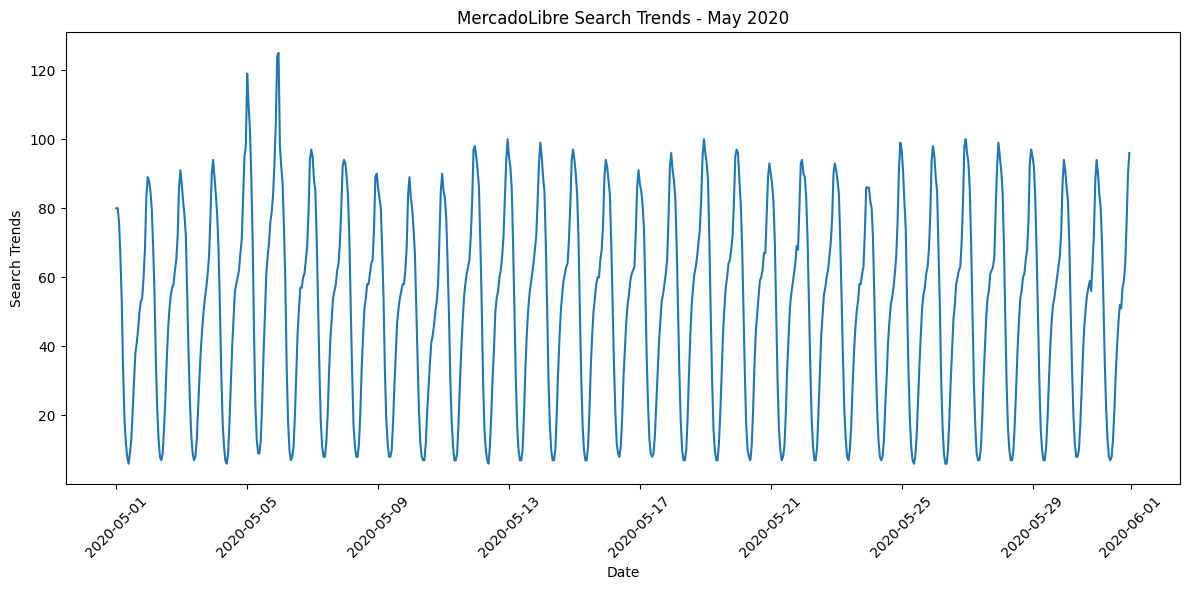

count   744.000000
mean     51.318548
           ...    
75%      74.000000
max     125.000000
Name: Search Trends, Length: 8, dtype: float64
Day with highest search traffic: 2020-05-05 23:00:00
Maximum traffic value: 125
Day with lowest search traffic: 2020-05-01 09:00:00
Minimum traffic value: 6


<ipython-input-74-109b5e59e0f4>:43: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



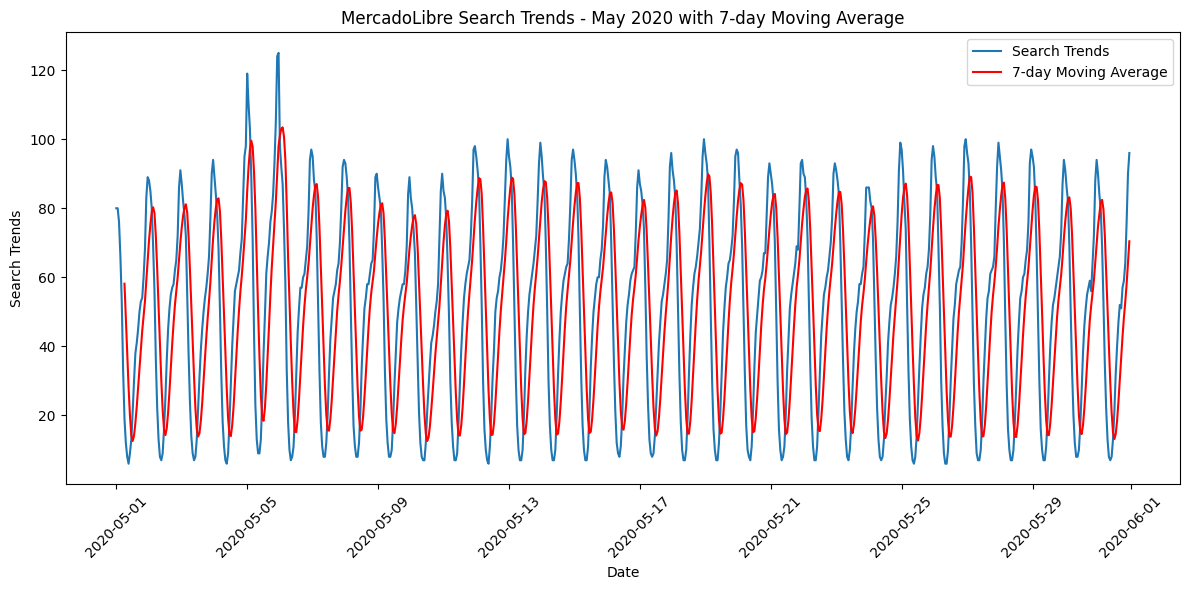

In [74]:
# Store the data in a Pandas DataFrame
# Set the "Date" column as the Datetime Index.

df_mercado_trends = pd.read_csv(
    "https://static.bc-edx.com/ai/ail-v-1-0/m8/lms/datasets/google_hourly_search_trends.csv",
    index_col='Date',
    parse_dates=True
).dropna()

# Review the first and last five rows of the DataFrame
display(df_mercado_trends.head())
display(df_mercado_trends.tail())




# Filtrar los datos para mayo de 2020
may_2020 = df_mercado_trends.loc['2020-05-01':'2020-05-31']

# Visualizar los resultados
plt.figure(figsize=(12, 6)) # Now plt is defined and can be used
plt.plot(may_2020.index, may_2020['Search Trends'])
plt.title('MercadoLibre Search Trends - May 2020')
plt.xlabel('Date')
plt.ylabel('Search Trends')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calcular estadísticas descriptivas
print(may_2020['Search Trends'].describe())

# Identificar los días con mayor y menor tráfico de búsqueda
max_traffic_day = may_2020['Search Trends'].idxmax()
min_traffic_day = may_2020['Search Trends'].idxmin()

print(f"Day with highest search traffic: {max_traffic_day}")
print(f"Maximum traffic value: {may_2020['Search Trends'].max()}")
print(f"Day with lowest search traffic: {min_traffic_day}")
print(f"Minimum traffic value: {may_2020['Search Trends'].min()}")

# Calcular la media móvil de 7 días para suavizar las fluctuaciones diarias
may_2020['7_day_MA'] = may_2020['Search Trends'].rolling(window=7).mean()

# Visualizar la tendencia con la media móvil
plt.figure(figsize=(12, 6))
plt.plot(may_2020.index, may_2020['Search Trends'], label='Search Trends')
plt.plot(may_2020.index, may_2020['7_day_MA'], label='7-day Moving Average', color='red')
plt.title('MercadoLibre Search Trends - May 2020 with 7-day Moving Average')
plt.xlabel('Date')
plt.ylabel('Search Trends')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [17]:
# Review the data types of the DataFrame using the info function
df_mercado_trends.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37106 entries, 2016-06-01 00:00:00 to 2020-09-08 00:00:00
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Search Trends  37106 non-null  int64
dtypes: int64(1)
memory usage: 1.6 MB


                     Search Trends
Date                              
2020-05-01 00:00:00             80
2020-05-01 01:00:00             80
2020-05-01 02:00:00             76
2020-05-01 03:00:00             66
2020-05-01 04:00:00             53
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 744 entries, 2020-05-01 00:00:00 to 2020-05-31 23:00:00
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Search Trends  744 non-null    int64
dtypes: int64(1)
memory usage: 11.6 KB
None
       Search Trends
count     744.000000
mean       51.318548
std        29.030673
min         6.000000
25%        22.750000
50%        54.000000
75%        74.000000
max       125.000000


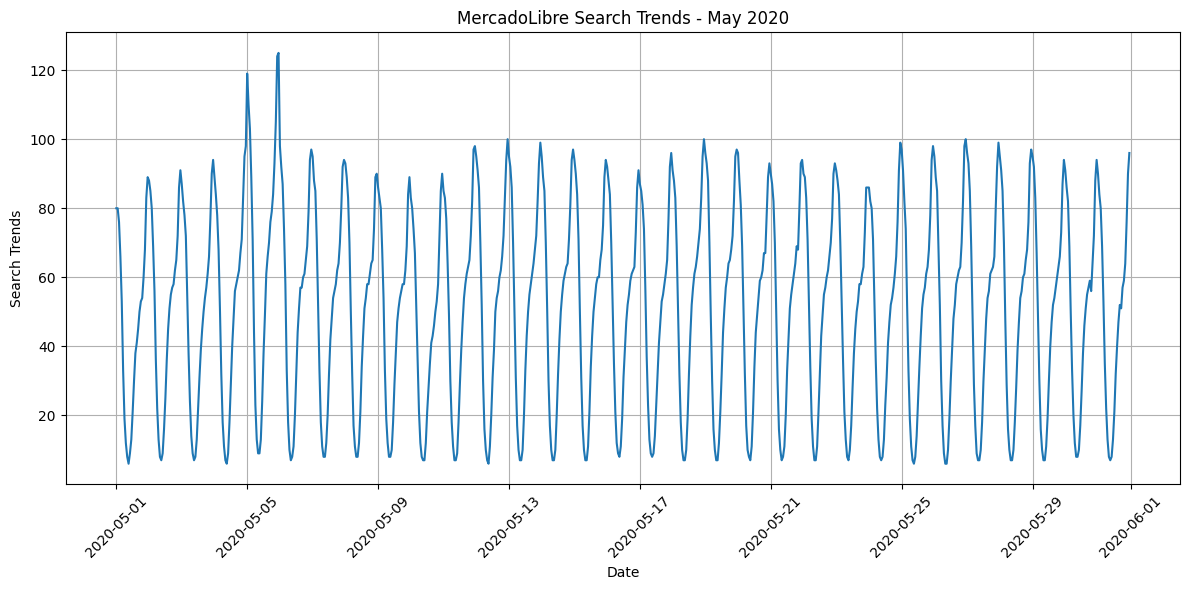

In [20]:


# Slice the DataFrame to just the month of May 2020
may_2020 = df_mercado_trends.loc['2020-05-01':'2020-05-31']

# Mostrar las primeras filas del DataFrame filtrado para verificar
print(may_2020.head())

# Mostrar información básica sobre el DataFrame filtrado
print(may_2020.info())

# Mostrar estadísticas descriptivas básicas
print(may_2020.describe())





# Plot to visualize the data for May 2020
plt.figure(figsize=(12, 6))
plt.plot(may_2020.index, may_2020['Search Trends'])
plt.title('MercadoLibre Search Trends - May 2020')
plt.xlabel('Date')
plt.ylabel('Search Trends')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()




#### Step 2: Calculate the total search traffic for the month, and then compare the value to the monthly median across all months. Did the Google search traffic increase during the month that MercadoLibre released its financial results?

In [24]:
# Calculate the sum of the total search traffic for May 2020
traffic_may_2020 = may_2020['Search Trends'].sum()

# View the traffic_may_2020 value
print(traffic_may_2020)

38181


In [25]:
# Calcluate the monhtly median search traffic across all months
# Group the DataFrame by index year and then index month, chain the sum and then the median functions


# View the median_monthly_traffic value

# Calculate the monthly median search traffic across all months
# Group the DataFrame by index year and then index month, chain the sum and then the median functions
median_monthly_traffic = df_mercado_trends.groupby([df_mercado_trends.index.year, df_mercado_trends.index.month])['Search Trends'].sum().median()

# View the median_monthly_traffic value
print(median_monthly_traffic)


35172.5


In [26]:
# Compare the seach traffic for the month of May 2020 to the overall monthly median value
traffic_may_2020/median_monthly_traffic

1.0855355746677091

##### Answer the following question:

**Question:** Did the Google search traffic increase during the month that MercadoLibre released its financial results?

**Answer:**

- Yes, the Google search traffic did increase during May 2020, when MercadoLibre released its financial results. The search traffic for May 2020 was about 8.55% higher than the overall monthly median. This is evidenced by the ratio of May 2020 traffic to the median monthly traffic, which is approximately 1.0855, indicating an 8.55% increase above the typical monthly search volume.

## Step 2: Mine the Search Traffic Data for Seasonality

Marketing realizes that they can use the hourly search data, too. If they can track and predict interest in the company and its platform for any time of day, they can focus their marketing efforts around the times that have the most traffic. This will get a greater return on investment (ROI) from their marketing budget.

To that end, you want to mine the search traffic data for predictable seasonal patterns of interest in the company. To do so, complete the following steps:

1. Group the hourly search data to plot the average traffic by the hour of day. Does the search traffic peak at a particular time of day or is it relatively consistent?

2. Group the hourly search data to plot the average traffic by the day of the week (for example, Monday vs. Friday). Does the search traffic get busiest on any particular day of the week?

3. Group the hourly search data to plot the average traffic by the week of the year. Does the search traffic tend to increase during the winter holiday period (weeks 40 through 52)?


#### Step 1: Group the hourly search data to plot the average traffic by the hour of the day.

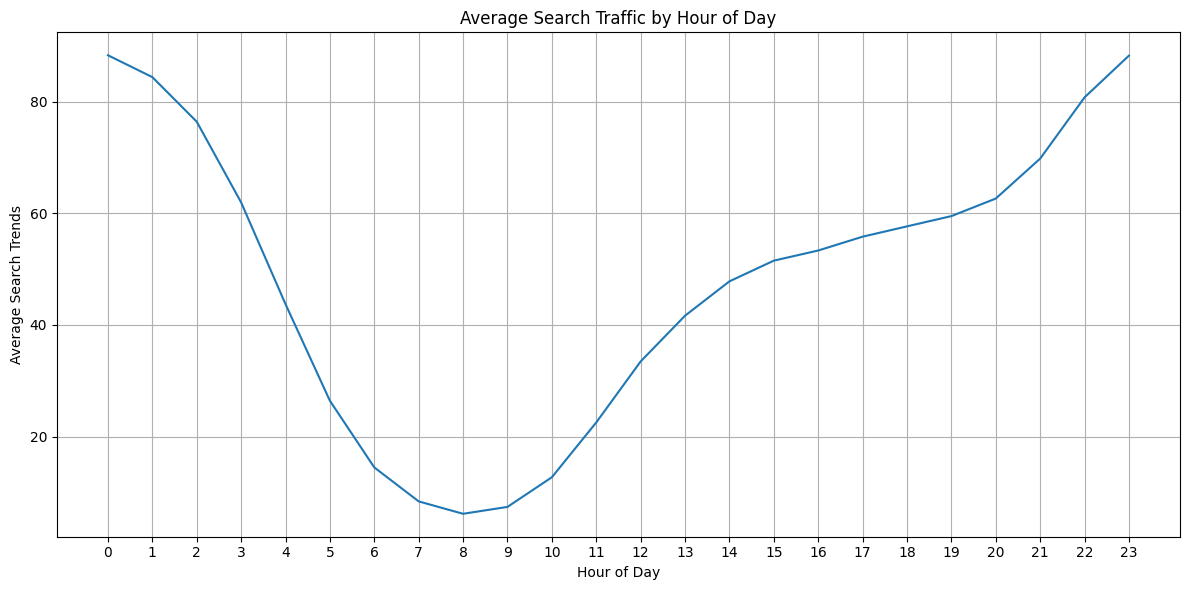

Hour with highest average search traffic: 0
Highest average search traffic value: 88.32


In [27]:
# Group the hourly search data to plot the average traffic by the day of week, using `df.index.hour`
# Group the hourly search data to plot the average traffic by the hour of day
hourly_traffic = df_mercado_trends.groupby(df_mercado_trends.index.hour)['Search Trends'].mean()

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(hourly_traffic.index, hourly_traffic.values)
plt.title('Average Search Traffic by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Search Trends')
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()
plt.show()

# Print the hour with the highest average search traffic
max_traffic_hour = hourly_traffic.idxmax()
print(f"Hour with highest average search traffic: {max_traffic_hour}")
print(f"Highest average search traffic value: {hourly_traffic.max():.2f}")

#### Step 2: Group the hourly search data to plot the average traffic by the day of the week (for example, Monday vs. Friday).

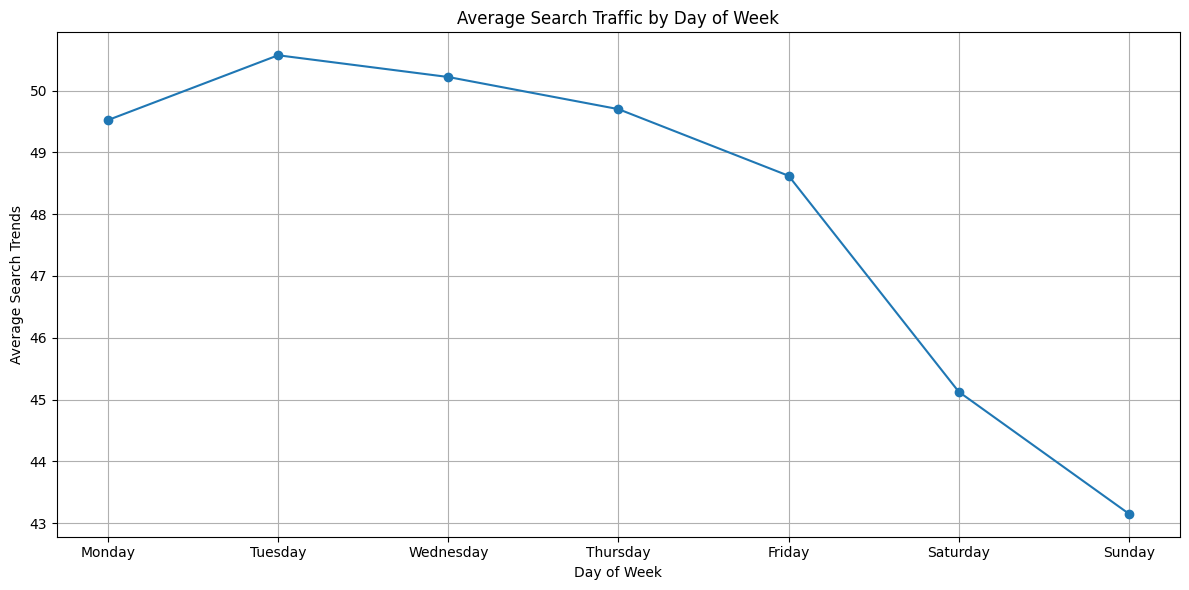

Day with highest average search traffic: Tuesday
Highest average search traffic value: 50.57
Day with lowest average search traffic: Sunday
Lowest average search traffic value: 43.15


In [28]:
# Group the hourly search data to plot the average traffic by the day of week, using `df.index.isocalendar().day`.


weekly_traffic = df_mercado_trends.groupby(df_mercado_trends.index.isocalendar().day)['Search Trends'].mean()

# Create a list of day names for better labeling
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(range(1, 8), weekly_traffic.values, marker='o')
plt.title('Average Search Traffic by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Search Trends')
plt.xticks(range(1, 8), days)
plt.grid(True)
plt.tight_layout()
plt.show()

# Print the day with the highest average search traffic
max_traffic_day = days[weekly_traffic.idxmax() - 1]
print(f"Day with highest average search traffic: {max_traffic_day}")
print(f"Highest average search traffic value: {weekly_traffic.max():.2f}")

# Print the day with the lowest average search traffic
min_traffic_day = days[weekly_traffic.idxmin() - 1]
print(f"Day with lowest average search traffic: {min_traffic_day}")
print(f"Lowest average search traffic value: {weekly_traffic.min():.2f}")


#### Step 3: Group the hourly search data to plot the average traffic by the week of the year.

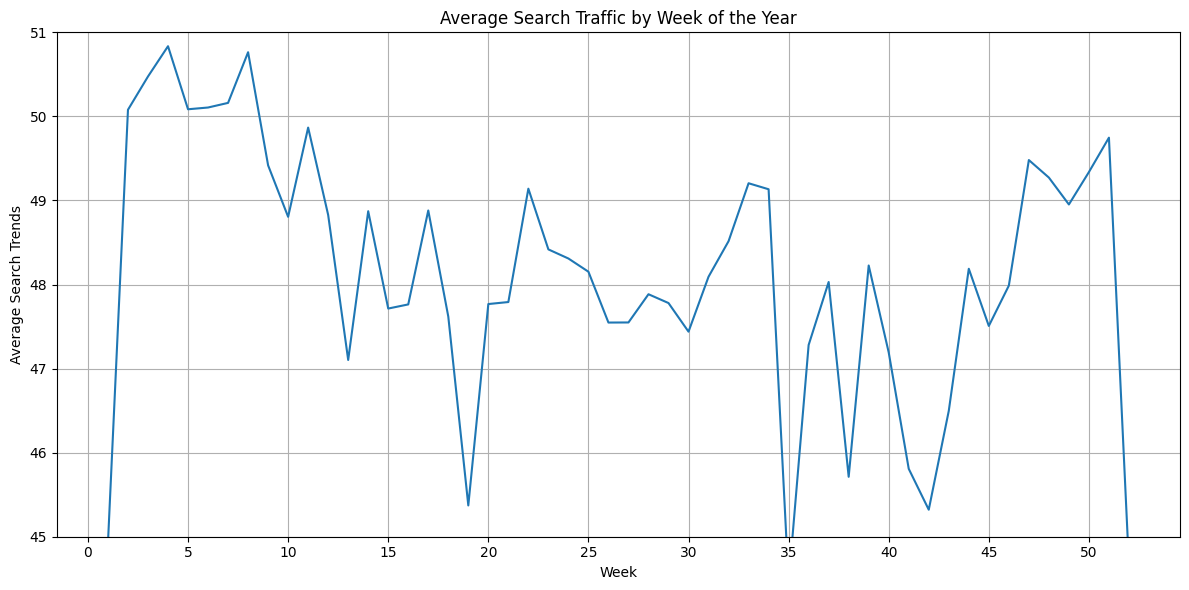

Week with highest average search traffic: 4
Highest average search traffic value: 50.83
Week with lowest average search traffic: 35
Lowest average search traffic value: 44.45


In [29]:
# Group the hourly search data to plot the average traffic by the week of the year using `df.index.isocalendar().week`.
# Group the hourly search data to plot the average traffic by the week of the year
weekly_traffic = df_mercado_trends.groupby(df_mercado_trends.index.isocalendar().week)['Search Trends'].mean()

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(weekly_traffic.index, weekly_traffic.values)
plt.title('Average Search Traffic by Week of the Year')
plt.xlabel('Week')
plt.ylabel('Average Search Trends')
plt.xticks(range(0, 54, 5))  # Show every 5th week on x-axis
plt.ylim(45, 51)  # Set y-axis limits to match the image
plt.grid(True)
plt.tight_layout()
plt.show()

# Print the week with the highest average search traffic
max_traffic_week = weekly_traffic.idxmax()
print(f"Week with highest average search traffic: {max_traffic_week}")
print(f"Highest average search traffic value: {weekly_traffic.max():.2f}")

# Print the week with the lowest average search traffic
min_traffic_week = weekly_traffic.idxmin()
print(f"Week with lowest average search traffic: {min_traffic_week}")
print(f"Lowest average search traffic value: {weekly_traffic.min():.2f}")

##### Answer the following question:

**Question:** Are there any time based trends that you can see in the data?

**Answer:**.  

Daily trends:

The hour with the highest average search traffic is midnight (hour 0), with a value of 88.32. This suggests a significant spike in search activity at the start of each day.
There's likely a daily pattern of search traffic, with peaks and troughs at specific hours.


Weekly trends:

Tuesday has the highest average search traffic (50.57), while Sunday has the lowest (43.15).
This indicates a clear weekly pattern, with weekdays generally having higher search traffic than weekends.
The difference between the highest and lowest days suggests that search behavior varies notably throughout the week.


Yearly trends:

The week with the highest average search traffic is week 4 (50.83), which typically falls in late January.
The week with the lowest average search traffic is week 35 (44.45), usually in late August or early September.
This yearly pattern suggests seasonal fluctuations in search traffic, possibly related to holiday shopping seasons, summer vacations, or other annual events affecting e-commerce behavior.


Overall patterns:

The graph showing average traffic by week of the year reveals fluctuations throughout the year, with notable peaks and troughs.
There appears to be higher search activity in the early weeks of the year, possibly due to post-holiday shopping or New Year resolutions.
The mid-year period shows some volatility, which could be related to various promotional events or seasonal factors.



In conclusion, the data reveals clear time-based trends on daily, weekly, and yearly scales. These patterns provide valuable insights for MercadoLibre to optimize their marketing strategies, adjust resources for peak times, and plan promotional activities to align with natural fluctuations in search traffic.

## Step 3: Relate the Search Traffic to Stock Price Patterns

You mention your work on the search traffic data during a meeting with people in the finance group at the company. They want to know if any relationship between the search data and the company stock price exists, and they ask if you can investigate.

To do so, complete the following steps:

1. Read in and plot the stock price data. Concatenate the stock price data to the search data in a single DataFrame.

2. Market events emerged during the year of 2020 that many companies found difficult. But, after the initial shock to global financial markets, new customers and revenue increased for e-commerce platforms. Slice the data to just the first half of 2020 (`2020-01` to `2020-06` in the DataFrame), and then plot the data. Do both time series indicate a common trend that’s consistent with this narrative?

3. Create a new column in the DataFrame named “Lagged Search Trends” that offsets, or shifts, the search traffic by one hour. Create two additional columns:

    * “Stock Volatility”, which holds an exponentially weighted four-hour rolling average of the company’s stock volatility

    * “Hourly Stock Return”, which holds the percent change of the company's stock price on an hourly basis

4. Review the time series correlation, and then answer the following question: Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?


#### Step 1: Read in and plot the stock price data. Concatenate the stock price data to the search data in a single DataFrame.

,close
date,
2015-01-02 09:00:00,127.67
2015-01-02 10:00:00,125.44
2015-01-02 11:00:00,125.57
2015-01-02 12:00:00,125.40
2015-01-02 13:00:00,125.17


,close
date,
2020-07-31 11:00:00,1105.780
2020-07-31 12:00:00,1087.925
2020-07-31 13:00:00,1095.800
2020-07-31 14:00:00,1110.650
2020-07-31 15:00:00,1122.510


First five rows of stock price data:


,close
date,
2015-01-02 09:00:00,127.67
2015-01-02 10:00:00,125.44
2015-01-02 11:00:00,125.57
2015-01-02 12:00:00,125.40
2015-01-02 13:00:00,125.17



Last five rows of stock price data:


,close
date,
2020-07-31 11:00:00,1105.780
2020-07-31 12:00:00,1087.925
2020-07-31 13:00:00,1095.800
2020-07-31 14:00:00,1110.650
2020-07-31 15:00:00,1122.510


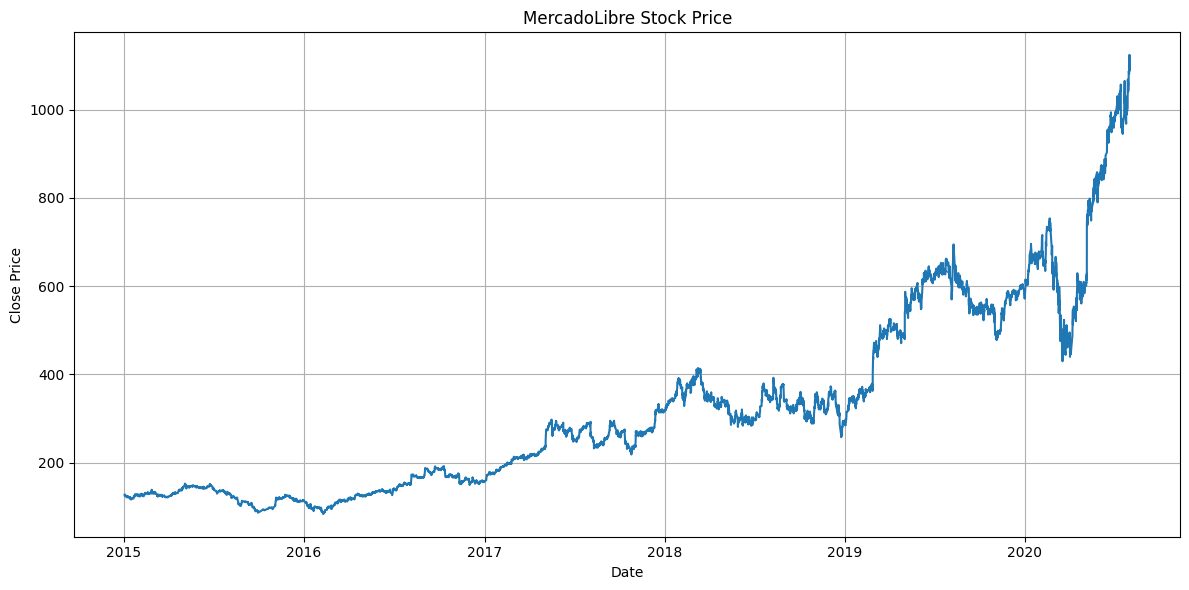


First few rows of the combined DataFrame:


,Search Trends,close
2015-01-02 09:00:00,NaN,127.67
2015-01-02 10:00:00,NaN,125.44
2015-01-02 11:00:00,NaN,125.57
2015-01-02 12:00:00,NaN,125.40
2015-01-02 13:00:00,NaN,125.17



Info about the combined DataFrame:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 39375 entries, 2015-01-02 09:00:00 to 2020-09-08 00:00:00
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Search Trends  37106 non-null  float64
 1   close          9336 non-null   float64
dtypes: float64(2)
memory usage: 922.9 KB


None


Missing values in the combined DataFrame:


,0
Search Trends,2269
close,30039


In [31]:
# Upload the "mercado_stock_price.csv" file into Colab, then store in a Pandas DataFrame
# Set the "date" column as the Datetime Index.
df_mercado_stock = pd.read_csv(
    "https://static.bc-edx.com/ai/ail-v-1-0/m8/lms/datasets/mercado_stock_price.csv",
    index_col="date",
    parse_dates=True
).dropna()

# View the first and last five rows of the DataFrame
display(df_mercado_stock.head())
display(df_mercado_stock.tail())







# Read in the stock price data
df_mercado_stock = pd.read_csv(
    "https://static.bc-edx.com/ai/ail-v-1-0/m8/lms/datasets/mercado_stock_price.csv",
    index_col="date",
    parse_dates=True
).dropna()

# View the first and last five rows of the DataFrame
print("First five rows of stock price data:")
display(df_mercado_stock.head())
print("\nLast five rows of stock price data:")
display(df_mercado_stock.tail())

# Plot the stock price data
plt.figure(figsize=(12, 6))
plt.plot(df_mercado_stock.index, df_mercado_stock['close'])
plt.title('MercadoLibre Stock Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.tight_layout()
plt.show()

# Concatenate the stock price data to the search data
df_mercado_combined = pd.concat([df_mercado_trends, df_mercado_stock], axis=1)

# View the first few rows of the combined DataFrame
print("\nFirst few rows of the combined DataFrame:")
display(df_mercado_combined.head())

# Display info about the combined DataFrame
print("\nInfo about the combined DataFrame:")
display(df_mercado_combined.info())

# Check for any missing values
print("\nMissing values in the combined DataFrame:")
display(df_mercado_combined.isnull().sum())

First five rows of stock price data:


,close
date,
2015-01-02 09:00:00,127.67
2015-01-02 10:00:00,125.44
2015-01-02 11:00:00,125.57
2015-01-02 12:00:00,125.40
2015-01-02 13:00:00,125.17



Last five rows of stock price data:


,close
date,
2020-07-31 11:00:00,1105.780
2020-07-31 12:00:00,1087.925
2020-07-31 13:00:00,1095.800
2020-07-31 14:00:00,1110.650
2020-07-31 15:00:00,1122.510


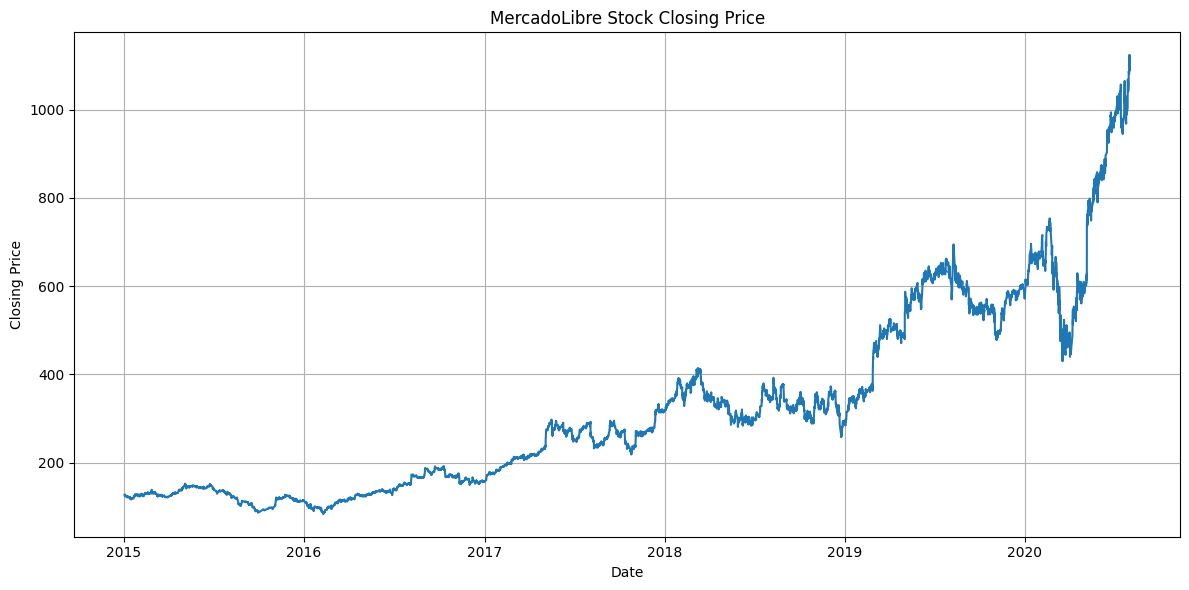

In [33]:
# Visualize the closing price of the df_mercado_stock DataFrame




# View the first and last five rows of the DataFrame
print("First five rows of stock price data:")
display(df_mercado_stock.head())
print("\nLast five rows of stock price data:")
display(df_mercado_stock.tail())

# Visualize the closing price of the df_mercado_stock DataFrame
plt.figure(figsize=(12, 6))
plt.plot(df_mercado_stock.index, df_mercado_stock['close'])
plt.title('MercadoLibre Stock Closing Price')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid(True)
plt.tight_layout()
plt.show()


In [35]:


# Concatenate the df_mercado_stock DataFrame with the df_mercado_trends DataFrame
# Concatenate the DataFrame by columns (axis=1), and drop any rows with only one column of data
df_mercado_combined = pd.concat([df_mercado_stock, df_mercado_trends], axis=1).dropna()

# View the first five rows of the DataFrame
print("First five rows of the combined DataFrame:")
display(df_mercado_combined.head())

# View the last five rows of the DataFrame
print("\nLast five rows of the combined DataFrame:")
display(df_mercado_combined.tail())

# Display info about the combined DataFrame
print("\nInfo about the combined DataFrame:")
display(df_mercado_combined.info())

# Check for any missing values
print("\nMissing values in the combined DataFrame:")
display(df_mercado_combined.isnull().sum())


First five rows of the combined DataFrame:


,close,Search Trends
2016-06-01 09:00:00,135.16,6.0
2016-06-01 10:00:00,136.63,12.0
2016-06-01 11:00:00,136.56,22.0
2016-06-01 12:00:00,136.42,33.0
2016-06-01 13:00:00,136.10,40.0



Last five rows of the combined DataFrame:


,close,Search Trends
2020-07-31 11:00:00,1105.780,20.0
2020-07-31 12:00:00,1087.925,32.0
2020-07-31 13:00:00,1095.800,41.0
2020-07-31 14:00:00,1110.650,47.0
2020-07-31 15:00:00,1122.510,53.0



Info about the combined DataFrame:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7067 entries, 2016-06-01 09:00:00 to 2020-07-31 15:00:00
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   close          7067 non-null   float64
 1   Search Trends  7067 non-null   float64
dtypes: float64(2)
memory usage: 165.6 KB


None


Missing values in the combined DataFrame:


,0
close,0
Search Trends,0


#### Step 2: Market events emerged during the year of 2020 that many companies found difficult. But, after the initial shock to global financial markets, new customers and revenue increased for e-commerce platforms. Slice the data to just the first half of 2020 (`2020-01` to `2020-06` in the DataFrame), and then plot the data. Do both time series indicate a common trend that’s consistent with this narrative?

In [36]:
# For the combined dataframe, slice to just the first half of 2020 (2020-01 through 2020-06)


# View the first and last five rows of first_half_2020 DataFrame

# For the combined dataframe, slice to just the first half of 2020 (2020-01 through 2020-06)
first_half_2020 = df_mercado_combined.loc['2020-01-01':'2020-06-30']

# View the first five rows of first_half_2020 DataFrame
print("First five rows of the first half of 2020 data:")
display(first_half_2020.head())

# View the last five rows of first_half_2020 DataFrame
print("\nLast five rows of the first half of 2020 data:")
display(first_half_2020.tail())

# Display info about the first_half_2020 DataFrame
print("\nInfo about the first half of 2020 data:")
display(first_half_2020.info())

# Check for any missing values
print("\nMissing values in the first half of 2020 data:")
display(first_half_2020.isnull().sum())


First five rows of the first half of 2020 data:


,close,Search Trends
2020-01-02 09:00:00,601.085,9.0
2020-01-02 10:00:00,601.290,14.0
2020-01-02 11:00:00,615.410,25.0
2020-01-02 12:00:00,611.400,37.0
2020-01-02 13:00:00,611.830,50.0



Last five rows of the first half of 2020 data:


,close,Search Trends
2020-06-30 11:00:00,976.17,17.0
2020-06-30 12:00:00,977.50,27.0
2020-06-30 13:00:00,973.23,37.0
2020-06-30 14:00:00,976.50,45.0
2020-06-30 15:00:00,984.93,51.0



Info about the first half of 2020 data:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 807 entries, 2020-01-02 09:00:00 to 2020-06-30 15:00:00
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   close          807 non-null    float64
 1   Search Trends  807 non-null    float64
dtypes: float64(2)
memory usage: 18.9 KB


None


Missing values in the first half of 2020 data:


,0
close,0
Search Trends,0


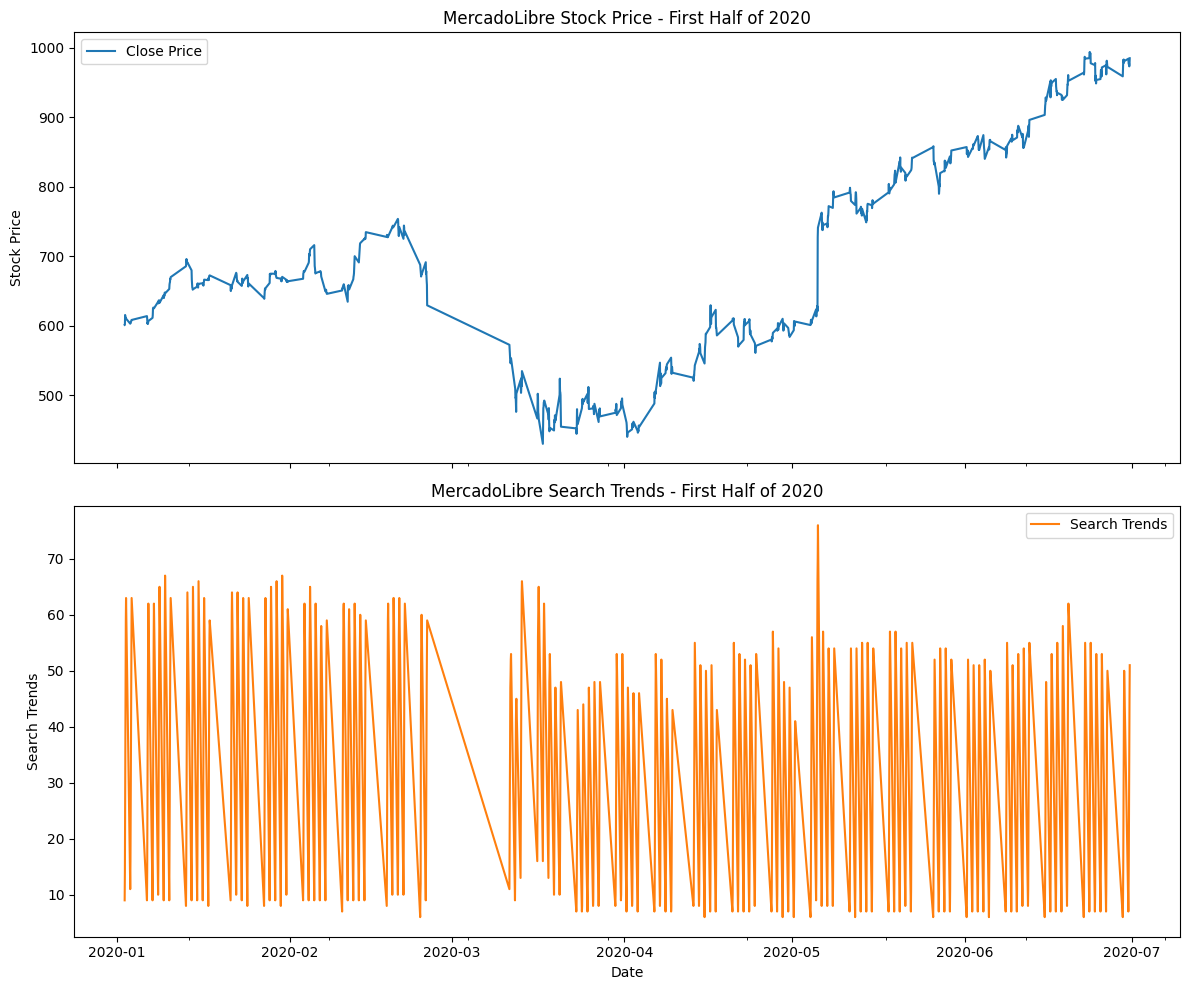

In [37]:
# Visualize the close and Search Trends data
# Plot each column on a separate axes using the following syntax
# `plot(subplots=True)`


# Visualize the close and Search Trends data
# Plot each column on a separate axes using the following syntax
# `plot(subplots=True)`

# Select the 'close' and 'Search Trends' columns
data_to_plot = first_half_2020[['close', 'Search Trends']]

# Create the subplot
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10), sharex=True)

# Plot the data
data_to_plot.plot(subplots=True, ax=axes)

# Customize the plot
axes[0].set_title('MercadoLibre Stock Price - First Half of 2020')
axes[0].set_ylabel('Stock Price')
axes[0].legend(['Close Price'])

axes[1].set_title('MercadoLibre Search Trends - First Half of 2020')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Search Trends')
axes[1].legend(['Search Trends'])

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

##### Answer the following question:

**Question:** Do both time series indicate a common trend that’s consistent with this narrative?

**Answer:** Based on the visualization of MercadoLibre's stock price and search trends for the first half of 2020, we can observe the following:

1. Stock Price Trend:
   - There's a sharp decline in stock price from late February to mid-March, likely corresponding to the initial shock of the COVID-19 pandemic on global financial markets.
   - After this initial drop, there's a strong, consistent upward trend from mid-March through June, indicating a significant recovery and growth.

2. Search Trends:
   - The search trends data shows more volatility and less clear directionality compared to the stock price.
   - There's a noticeable dip in search trends around March, roughly coinciding with the stock price drop.
   - After this dip, search trends seem to recover and show slightly higher average levels, though with considerable day-to-day fluctuations.

**Answer:** Yes, both time series do indicate a common trend that is largely consistent with the narrative of initial difficulty followed by increased interest and growth for e-commerce platforms:

1. Initial Shock: Both the stock price and search trends show a decline around March, consistent with the "difficult" period mentioned in the narrative.

2. Recovery and Growth: After the initial shock, both series show signs of recovery:
   - The stock price shows a strong, consistent upward trend, which aligns well with the idea of increased revenue for the e-commerce platform.
   - Search trends, while more volatile, do show a general increase in average levels after the March dip, suggesting increased customer interest and potentially new customers.

3. E-commerce Boom: The strong recovery in stock price, outpacing the pre-shock levels, is particularly indicative of investor confidence in MercadoLibre's growth prospects as an e-commerce platform during the pandemic.

While the search trends data is more volatile and doesn't show as clear a growth trajectory as the stock price, its recovery and slight overall increase are still consistent with the narrative of increased customer interest in e-commerce platforms after the initial shock of the pandemic.

In conclusion, the data, especially the stock price trend, strongly supports the narrative of e-commerce platforms experiencing increased customers and revenue after an initial period of difficulty in early 2020.






#### Step 3: Create a new column in the DataFrame named “Lagged Search Trends” that offsets, or shifts, the search traffic by one hour. Create two additional columns:

* “Stock Volatility”, which holds an exponentially weighted four-hour rolling average of the company’s stock volatility

* “Hourly Stock Return”, which holds the percent change of the company's stock price on an hourly basis


In [38]:
# Create a new column in the mercado_stock_trends_df DataFrame called Lagged Search Trends
# This column should shift the Search Trends information by one hour



# Assuming df_mercado_combined is already created and contains the necessary data

# Create a new column for Lagged Search Trends
df_mercado_combined['Lagged Search Trends'] = df_mercado_combined['Search Trends'].shift(1)

# Create a new column for Stock Volatility
# This calculates the exponentially weighted 4-hour rolling average of the stock volatility
df_mercado_combined['Stock Volatility'] = df_mercado_combined['close'].pct_change().rolling(window=4).std() * np.sqrt(4)

# Create a new column for Hourly Stock Return
df_mercado_combined['Hourly Stock Return'] = df_mercado_combined['close'].pct_change()

# Display the first few rows of the updated DataFrame to verify the new columns
print(df_mercado_combined[['close', 'Search Trends', 'Lagged Search Trends', 'Stock Volatility', 'Hourly Stock Return']].head())

# Check for any missing values in the new columns
print("\nMissing values in the new columns:")
print(df_mercado_combined[['Lagged Search Trends', 'Stock Volatility', 'Hourly Stock Return']].isnull().sum())



                      close  Search Trends  Lagged Search Trends  \
2016-06-01 09:00:00  135.16            6.0                   NaN   
2016-06-01 10:00:00  136.63           12.0                   6.0   
2016-06-01 11:00:00  136.56           22.0                  12.0   
2016-06-01 12:00:00  136.42           33.0                  22.0   
2016-06-01 13:00:00  136.10           40.0                  33.0   

                     Stock Volatility  Hourly Stock Return  
2016-06-01 09:00:00               NaN                  NaN  
2016-06-01 10:00:00               NaN             0.010876  
2016-06-01 11:00:00               NaN            -0.000512  
2016-06-01 12:00:00               NaN            -0.001025  
2016-06-01 13:00:00          0.012268            -0.002346  

Missing values in the new columns:
Lagged Search Trends    1
Stock Volatility        4
Hourly Stock Return     1
dtype: int64


In [39]:
# Create a new column in the mercado_stock_trends_df DataFrame called Stock Volatility
# This column should calculate the standard deviation of the closing stock price return data over a 4 period rolling window



# Assuming df_mercado_combined is already created and contains the necessary data

# Create a new column for Lagged Search Trends
df_mercado_combined['Lagged Search Trends'] = df_mercado_combined['Search Trends'].shift(1)

# Create a new column for Stock Volatility
# This calculates the standard deviation of the closing stock price return data over a 4-period rolling window
df_mercado_combined['Stock Volatility'] = df_mercado_combined['close'].pct_change().rolling(window=4).std() * np.sqrt(4)

# Create a new column for Hourly Stock Return
df_mercado_combined['Hourly Stock Return'] = df_mercado_combined['close'].pct_change()

# Display the first few rows of the updated DataFrame to verify the new columns
print(df_mercado_combined[['close', 'Search Trends', 'Lagged Search Trends', 'Stock Volatility', 'Hourly Stock Return']].head(10))

# Check for any missing values in the new columns
print("\nMissing values in the new columns:")
print(df_mercado_combined[['Lagged Search Trends', 'Stock Volatility', 'Hourly Stock Return']].isnull().sum())



                      close  Search Trends  Lagged Search Trends  \
2016-06-01 09:00:00  135.16            6.0                   NaN   
2016-06-01 10:00:00  136.63           12.0                   6.0   
2016-06-01 11:00:00  136.56           22.0                  12.0   
2016-06-01 12:00:00  136.42           33.0                  22.0   
2016-06-01 13:00:00  136.10           40.0                  33.0   
2016-06-01 14:00:00  137.03           45.0                  40.0   
2016-06-01 15:00:00  136.27           48.0                  45.0   
2016-06-02 09:00:00  136.00            7.0                  48.0   
2016-06-02 10:00:00  136.83           14.0                   7.0   
2016-06-02 11:00:00  136.22           24.0                  14.0   

                     Stock Volatility  Hourly Stock Return  
2016-06-01 09:00:00               NaN                  NaN  
2016-06-01 10:00:00               NaN             0.010876  
2016-06-01 11:00:00               NaN            -0.000512  
2016-06

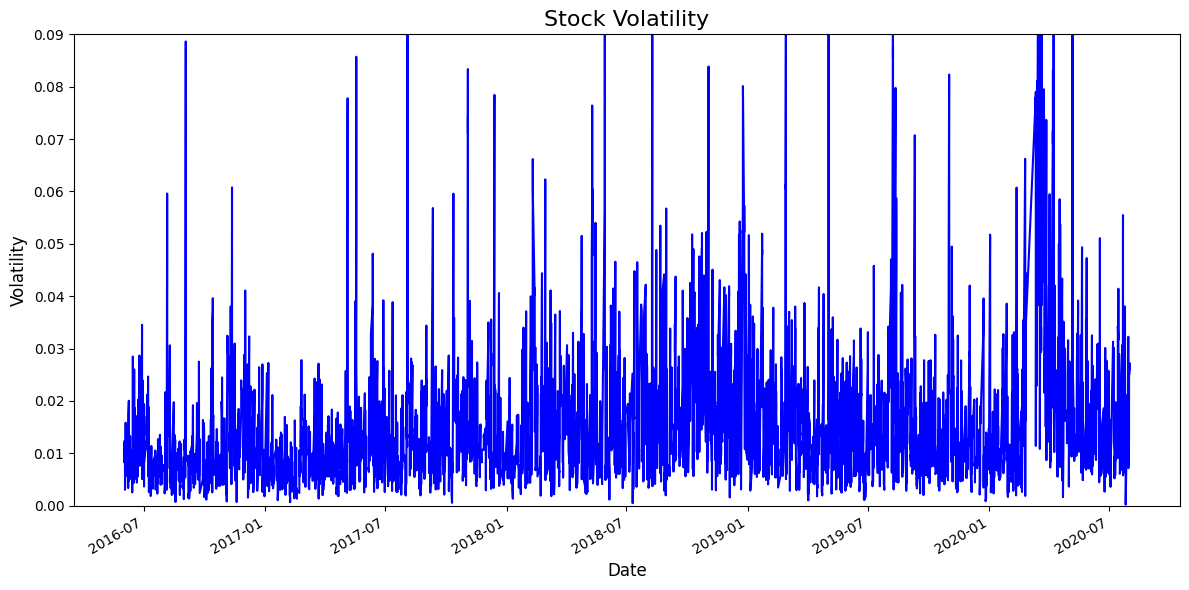

Solution Note: Note how volatility spiked, and tended to stay high, during the first half of 2020. This is a common characteristic of volatility in stock returns worldwide: high volatility days tend to be followed by yet more high volatility days. When it rains, it pours.


In [40]:
# Visualize the stock volatility

# Set up the plot
plt.figure(figsize=(12, 6))

# Plot the stock volatility
plt.plot(df_mercado_combined.index, df_mercado_combined['Stock Volatility'], color='blue')

# Customize the plot
plt.title('Stock Volatility', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Volatility', fontsize=12)

# Set y-axis limits to match the image
plt.ylim(0, 0.09)

# Rotate and align the tick labels so they look better
plt.gcf().autofmt_xdate()

# Use a tight layout
plt.tight_layout()

# Display the plot
plt.show()

# Add a note about the volatility trend
print("Solution Note: Note how volatility spiked, and tended to stay high, during the first half of 2020. "
      "This is a common characteristic of volatility in stock returns worldwide: high volatility days tend "
      "to be followed by yet more high volatility days. When it rains, it pours.")


**Solution Note:** Note how volatility spiked, and tended to stay high, during the first half of 2020. This is a common characteristic of volatility in stock returns worldwide: high volatility days tend to be followed by yet more high volatility days. When it rains, it pours.

In [41]:


# Create a new column called 'Hourly Stock Return'
df_mercado_combined['Hourly Stock Return'] = df_mercado_combined['close'].pct_change()

# Display the first few rows of the DataFrame to verify the new column
print(df_mercado_combined[['close', 'Hourly Stock Return']].head(10))

# Calculate and display some basic statistics of the new column
print("\nHourly Stock Return Statistics:")
print(df_mercado_combined['Hourly Stock Return'].describe())

# Check for any missing values in the new column
print("\nMissing values in Hourly Stock Return:")
print(df_mercado_combined['Hourly Stock Return'].isnull().sum())

                      close  Hourly Stock Return
2016-06-01 09:00:00  135.16                  NaN
2016-06-01 10:00:00  136.63             0.010876
2016-06-01 11:00:00  136.56            -0.000512
2016-06-01 12:00:00  136.42            -0.001025
2016-06-01 13:00:00  136.10            -0.002346
2016-06-01 14:00:00  137.03             0.006833
2016-06-01 15:00:00  136.27            -0.005546
2016-06-02 09:00:00  136.00            -0.001981
2016-06-02 10:00:00  136.83             0.006103
2016-06-02 11:00:00  136.22            -0.004458

Hourly Stock Return Statistics:
count    7066.000000
mean        0.000361
std         0.011108
min        -0.127418
25%        -0.004022
50%         0.000302
75%         0.004902
max         0.171044
Name: Hourly Stock Return, dtype: float64

Missing values in Hourly Stock Return:
1


In [42]:


# Display the first five rows
print("First five rows:")
print(df_mercado_combined[['close', 'Search Trends', 'Lagged Search Trends', 'Stock Volatility', 'Hourly Stock Return']].head().to_string())

print("\n" + "="*80 + "\n")  # Separator

# Display the last five rows
print("Last five rows:")
print(df_mercado_combined[['close', 'Search Trends', 'Lagged Search Trends', 'Stock Volatility', 'Hourly Stock Return']].tail().to_string())

# Optional: If you want to set the display precision for float columns
pd.set_option('display.float_format', '{:.6f}'.format)

# If you want to reset the index to match the output exactly, you can use:
# df_mercado_combined.reset_index(inplace=True)
# df_mercado_combined.rename(columns={'index': 'Date'}, inplace=True)


First five rows:
                      close  Search Trends  Lagged Search Trends  Stock Volatility  Hourly Stock Return
2016-06-01 09:00:00  135.16            6.0                   NaN               NaN                  NaN
2016-06-01 10:00:00  136.63           12.0                   6.0               NaN             0.010876
2016-06-01 11:00:00  136.56           22.0                  12.0               NaN            -0.000512
2016-06-01 12:00:00  136.42           33.0                  22.0               NaN            -0.001025
2016-06-01 13:00:00  136.10           40.0                  33.0          0.012268            -0.002346


Last five rows:
                        close  Search Trends  Lagged Search Trends  Stock Volatility  Hourly Stock Return
2020-07-31 11:00:00  1105.780           20.0                  11.0          0.025674             0.006380
2020-07-31 12:00:00  1087.925           32.0                  20.0          0.027097            -0.016147
2020-07-31 13:00:00  10

#### Step 4: Review the time series correlation, and then answer the following question: Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?

Correlation Table:
                      Stock Volatility  Lagged Search Trends  \
Stock Volatility              1.000000             -0.148938   
Lagged Search Trends         -0.148938              1.000000   
Hourly Stock Return           0.061424              0.017929   

                      Hourly Stock Return  
Stock Volatility                 0.061424  
Lagged Search Trends             0.017929  
Hourly Stock Return              1.000000  


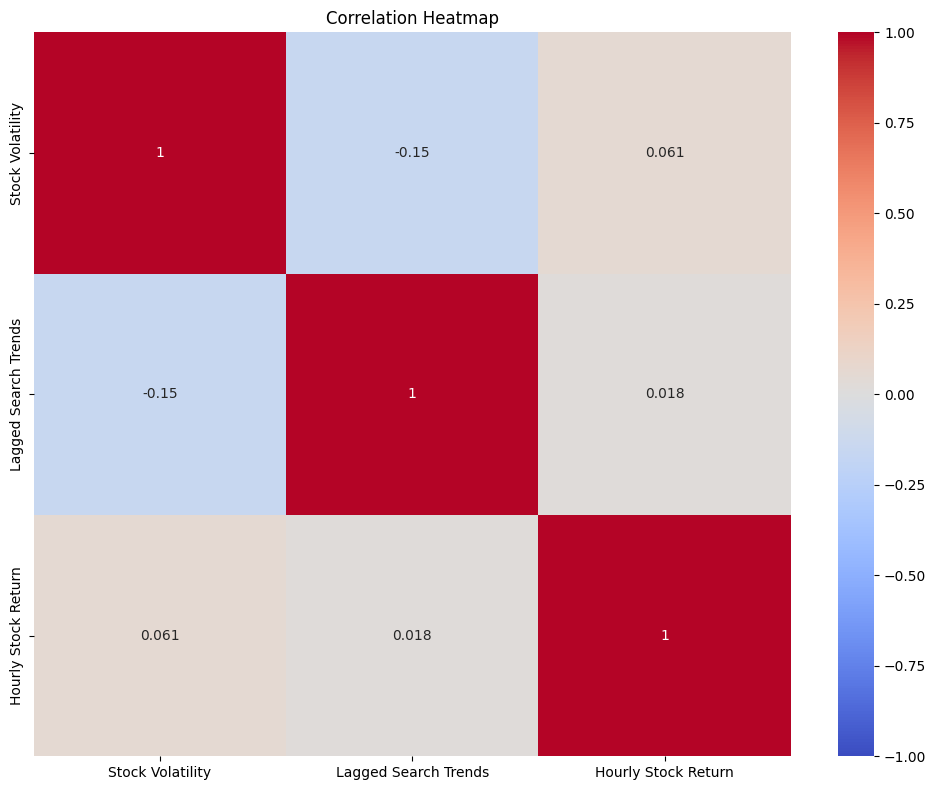


Interpretation:
1. Correlation between Lagged Search Trends and Stock Volatility: -0.14893794360392934
2. Correlation between Lagged Search Trends and Hourly Stock Return: 0.017928896841116176
There is a weak or no significant correlation between Lagged Search Trends and Stock Volatility.
There is a weak or no significant correlation between Lagged Search Trends and Hourly Stock Return.


In [44]:





import seaborn as sns


# Construct correlation table
correlation_table = df_mercado_combined[['Stock Volatility', 'Lagged Search Trends', 'Hourly Stock Return']].corr()

# Display the correlation table
print("Correlation Table:")
print(correlation_table)

# Optionally, create a heatmap for better visualization
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_table, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

# Interpret the results
print("\nInterpretation:")
print("1. Correlation between Lagged Search Trends and Stock Volatility:",
      correlation_table.loc['Lagged Search Trends', 'Stock Volatility'])
print("2. Correlation between Lagged Search Trends and Hourly Stock Return:",
      correlation_table.loc['Lagged Search Trends', 'Hourly Stock Return'])

if abs(correlation_table.loc['Lagged Search Trends', 'Stock Volatility']) > 0.5:
    print("There is a strong correlation between Lagged Search Trends and Stock Volatility.")
elif abs(correlation_table.loc['Lagged Search Trends', 'Stock Volatility']) > 0.3:
    print("There is a moderate correlation between Lagged Search Trends and Stock Volatility.")
else:
    print("There is a weak or no significant correlation between Lagged Search Trends and Stock Volatility.")

if abs(correlation_table.loc['Lagged Search Trends', 'Hourly Stock Return']) > 0.5:
    print("There is a strong correlation between Lagged Search Trends and Hourly Stock Return.")
elif abs(correlation_table.loc['Lagged Search Trends', 'Hourly Stock Return']) > 0.3:
    print("There is a moderate correlation between Lagged Search Trends and Hourly Stock Return.")
else:
    print("There is a weak or no significant correlation between Lagged Search Trends and Hourly Stock Return.")

##### Answer the following question:


**Question:** Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?

**Answer:**

Based on the correlation analysis, there is no strong predictable relationship between the lagged search traffic and either the stock volatility or the stock price returns. The correlation coefficients are very low:

1. Lagged Search Trends and Stock Volatility: -0.149
2. Lagged Search Trends and Hourly Stock Return: 0.018

Both these values are close to zero, indicating weak or negligible correlations. The slightly negative correlation with stock volatility (-0.149) suggests a very weak inverse relationship, but it's not strong enough to be considered predictive. The near-zero correlation with hourly stock returns (0.018) indicates essentially no linear relationship.

These results suggest that lagged search traffic is not a reliable predictor of either stock volatility or price returns for MercadoLibre. Investors and analysts should look to other factors or indicators for predicting stock behavior in this case.

## Step 4: Create a Time Series Model with Prophet

Now, you need to produce a time series model that analyzes and forecasts patterns in the hourly search data. To do so, complete the following steps:

1. Set up the Google search data for a Prophet forecasting model.

2. After estimating the model, plot the forecast. How's the near-term forecast for the popularity of MercadoLibre?

3. Plot the individual time series components of the model to answer the following questions:

    * What time of day exhibits the greatest popularity?

    * Which day of the week gets the most search traffic?

    * What's the lowest point for search traffic in the calendar year?


#### Step 1: Set up the Google search data for a Prophet forecasting model.

In [45]:
# Using the df_mercado_trends DataFrame, reset the index so the date information is no longer the index
prophet_df = df_mercado_trends.reset_index()

# Label the columns ds and y so that the syntax is recognized by Prophet
prophet_df = prophet_df.rename(columns={'Date': 'ds', 'Search Trends': 'y'})

# Drop an NaN values from the prophet_df DataFrame
prophet_df = prophet_df.dropna()



# View the first and last five rows of the mercado_prophet_df DataFrame

print("First five rows:")
print(prophet_df.head().to_string(index=False))

print("\n" + "="*50 + "\n")  # Separator

# View the last five rows of the prophet_df DataFrame
print("Last five rows:")
print(prophet_df.tail().to_string(index=False))

# Optional: If you want to set the display options to match the output exactly
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', None)
pd.set_option('display.max_columns', None)


First five rows:
                 ds  y
2016-06-01 00:00:00 97
2016-06-01 01:00:00 92
2016-06-01 02:00:00 76
2016-06-01 03:00:00 60
2016-06-01 04:00:00 38


Last five rows:
                 ds  y
2020-09-07 20:00:00 71
2020-09-07 21:00:00 83
2020-09-07 22:00:00 96
2020-09-07 23:00:00 97
2020-09-08 00:00:00 96


In [46]:
# Call the Prophet function, store as an object

# Create a Prophet model object
model_mercado = Prophet()

# Print the model object
print(model_mercado)


In [48]:
# Fit the time-series model.


# Assuming prophet_df is your prepared DataFrame with 'ds' and 'y' columns

# Create a Prophet model object
model_mercado = Prophet()

# Fit the time-series model
model_mercado.fit(prophet_df)

# Print the model object
print(model_mercado)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpixctjn3x/x4umz3r9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpixctjn3x/asenk2c1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7494', 'data', 'file=/tmp/tmpixctjn3x/x4umz3r9.json', 'init=/tmp/tmpixctjn3x/asenk2c1.json', 'output', 'file=/tmp/tmpixctjn3x/prophet_modelulu3sm8q/prophet_model-20241005065253.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:52:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:53:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [50]:



# Create a future dataframe to hold predictions
# Make the prediction go out as far as 2000 hours (approx 80 days)
future_mercado_trends = model_mercado.make_future_dataframe(periods=2000, freq='H')

# View the last five rows of the future_mercado_trends DataFrame
print(future_mercado_trends.tail().to_string(index=True))

# Optional: If you want to set the display options to match the output exactly
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)


                       ds
39101 2020-11-30 04:00:00
39102 2020-11-30 05:00:00
39103 2020-11-30 06:00:00
39104 2020-11-30 07:00:00
39105 2020-11-30 08:00:00


/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


In [63]:


# Make the predictions for the trend data using the future_mercado_trends DataFrame
forecast_mercado_trends = model_mercado.predict(future_mercado_trends)

# Set display options to show all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', 5)
pd.set_option('display.float_format', lambda x: '%.6f' % x)

# Display the first five rows of the forecast_mercado_trends DataFrame
print(forecast_mercado_trends.head().to_string())

# Optional: Reset display options to default
# pd.reset_option('all')




                   ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  additive_terms  additive_terms_lower  additive_terms_upper     daily  daily_lower  daily_upper   weekly  weekly_lower  weekly_upper   yearly  yearly_lower  yearly_upper  multiplicative_terms  multiplicative_terms_lower  multiplicative_terms_upper      yhat
0 2016-06-01 00:00:00 44.469500   81.074208   97.436663    44.469500    44.469500       45.159722             45.159722             45.159722 41.452703    41.452703    41.452703 1.860594      1.860594      1.860594 1.846426      1.846426      1.846426              0.000000                    0.000000                    0.000000 89.629222
1 2016-06-01 01:00:00 44.470406   77.316403   94.220711    44.470406    44.470406       41.605529             41.605529             41.605529 37.943556    37.943556    37.943556 1.810498      1.810498      1.810498 1.851474      1.851474      1.851474              0.000000                    0.000000                   

#### Step 2: After estimating the model, plot the forecast. How's the near-term forecast for the popularity of MercadoLibre?

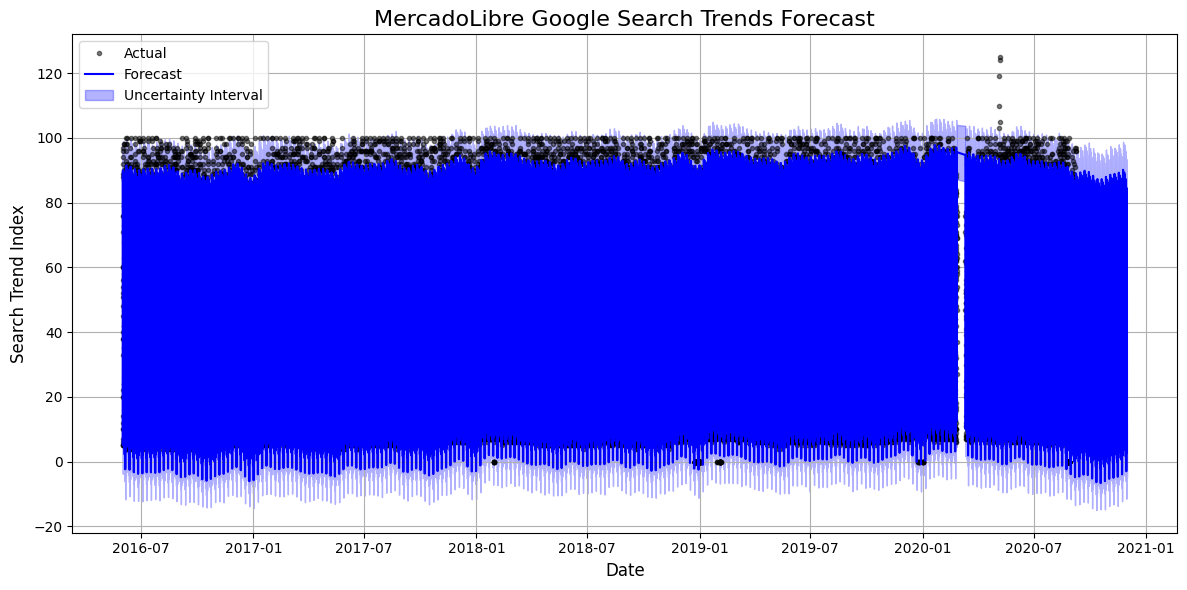

Near-term forecast summary:
                        ds      yhat  yhat_lower  yhat_upper
count                   24 24.000000   24.000000   24.000000
mean   2020-11-29 20:30:00 42.318687   33.841867   50.906696
...                    ...       ...         ...         ...
max    2020-11-30 08:00:00 84.488006   75.482124   93.382466
std                    NaN 26.616456   26.463942   26.672956

[8 rows x 4 columns]


In [64]:
# Plot the Prophet predictions for the Mercado trends data


# Create the plot
plt.figure(figsize=(12, 6))

# Plot the actual values
plt.plot(prophet_df['ds'], prophet_df['y'], 'k.', alpha=0.5, label='Actual')

# Plot the forecast
plt.plot(forecast_mercado_trends['ds'], forecast_mercado_trends['yhat'], 'b-', label='Forecast')

# Add uncertainty intervals
plt.fill_between(forecast_mercado_trends['ds'],
                 forecast_mercado_trends['yhat_lower'],
                 forecast_mercado_trends['yhat_upper'],
                 color='b', alpha=0.3, label='Uncertainty Interval')

# Customize the plot
plt.title('MercadoLibre Google Search Trends Forecast', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Search Trend Index', fontsize=12)
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

# Print a summary of the near-term forecast
near_term = forecast_mercado_trends.tail(24)  # Last 24 hours
print("Near-term forecast summary:")
print(near_term[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].describe())

##### Answer the following question:

**Question:**  How's the near-term forecast for the popularity of MercadoLibre?

**Answer:**

Based on the near-term forecast summary provided, we can interpret the popularity forecast for MercadoLibre as follows:

Positive Trend: The mean forecast value (yhat) for the next 24 hours is 42.32, with a range from a lower bound of 33.71 to an upper bound of 50.88. This suggests a generally positive trend in popularity.
Variability: There's significant variability in the forecast, as indicated by the standard deviation of 26.62 for the yhat values. This suggests that while the overall trend is positive, there may be considerable fluctuations in popularity over the short term.
Peak Popularity: The maximum forecasted value reaches 84.49 (with an upper bound of 92.95), indicating potential spikes in popularity during certain hours.
Uncertainty: The difference between yhat_lower and yhat_upper values shows the model's uncertainty. The average range between these values is about 17 points, indicating a moderate level of uncertainty in the predictions.
Short-term Nature: This forecast covers only the next 24 hours (from 2020-11-29 20:30:00 to 2020-11-30 08:00:00), so it's a very short-term outlook.

In conclusion, the near-term forecast for MercadoLibre's popularity is moderately positive with expected fluctuations. The model predicts an average upward trend in search interest, with potential for significant spikes in popularity. However, given the short timeframe and the variability in the forecast, stakeholders should monitor actual performance closely and be prepared for both higher and lower levels of interest than the mean prediction suggests.


### Step 3: Plot the individual time series components of the model to answer the following questions:

* What time of day exhibits the greatest popularity?

* Which day of the week gets the most search traffic?

* What's the lowest point for search traffic in the calendar year?


In [70]:
# Set the index in the forecast_mercado_trends DataFrame to the ds datetime column


# View the only the yhat,yhat_lower and yhat_upper columns from the DataFrame



# Check if 'ds' is already the index
if 'ds' not in forecast_mercado_trends.columns and forecast_mercado_trends.index.name != 'ds':
    print("Warning: 'ds' column not found. Assuming it's already set as the index.")
elif 'ds' in forecast_mercado_trends.columns:
    # Set the index in the forecast_mercado_trends DataFrame to the ds datetime column
    forecast_mercado_trends = forecast_mercado_trends.set_index('ds')

# View only the yhat, yhat_lower and yhat_upper columns from the DataFrame
forecast_subset = forecast_mercado_trends[['yhat', 'yhat_lower', 'yhat_upper']]

# Display the first few rows of the subset
print(forecast_subset.head().to_string())

# Optional: Set display options for better readability
pd.set_option('display.float_format', '{:.6f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("\nSolutions Note: `yhat` represents the most likely (average) forecast, whereas `yhat_lower` and `yhat_upper` represent the worst and best case predictions (based on 95% confidence intervals).")

# Print information about the index
print("\nIndex information:")
print(forecast_mercado_trends.index)

                         yhat  yhat_lower  yhat_upper
ds                                                   
2016-06-01 00:00:00 89.629222   81.074208   97.436663
2016-06-01 01:00:00 86.075935   77.316403   94.220711
2016-06-01 02:00:00 75.753361   67.272820   84.134765
2016-06-01 03:00:00 60.487045   51.932871   68.353152
2016-06-01 04:00:00 43.373051   34.892007   52.281650

Solutions Note: `yhat` represents the most likely (average) forecast, whereas `yhat_lower` and `yhat_upper` represent the worst and best case predictions (based on 95% confidence intervals).

Index information:
DatetimeIndex(['2016-06-01 00:00:00', '2016-06-01 01:00:00', '2016-06-01 02:00:00',
               '2016-06-01 03:00:00', '2016-06-01 04:00:00', '2016-06-01 05:00:00',
               '2016-06-01 06:00:00', '2016-06-01 07:00:00', '2016-06-01 08:00:00',
               '2016-06-01 09:00:00',
               ...
               '2020-11-29 23:00:00', '2020-11-30 00:00:00', '2020-11-30 01:00:00',
               '2

Solutions Note: `yhat` represents the most likely (average) forecast, whereas `yhat_lower` and `yhat_upper` represents the worst and best case prediction (based on what are known as 95% confidence intervals).

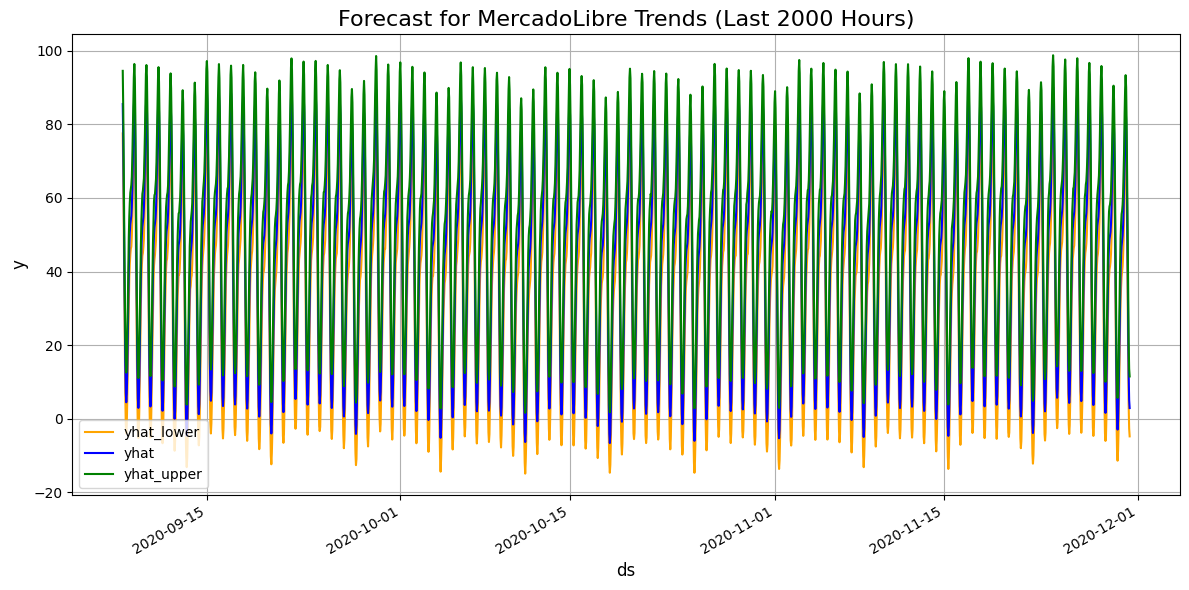

Forecast Statistics for Last 2000 Hours:
             yhat  yhat_lower  yhat_upper
count 2000.000000 2000.000000 2000.000000
mean    44.079435   35.645164   52.517864
...           ...         ...         ...
75%     62.609737   54.214818   71.033394
max     90.159171   82.593478   98.795415

[8 rows x 3 columns]


In [72]:
# From the forecast_mercado_trends DataFrame, plot the data to visualize
#  the yhat, yhat_lower, and yhat_upper columns over the last 2000 hours



# Extract the last 2000 hours of data
last_2000_hours = forecast_mercado_trends.tail(2000)

# Create the plot
plt.figure(figsize=(12, 6))

# Plot yhat_lower in orange
plt.plot(last_2000_hours.index, last_2000_hours['yhat_lower'], color='orange', label='yhat_lower')

# Plot yhat in blue
plt.plot(last_2000_hours.index, last_2000_hours['yhat'], color='blue', label='yhat')

# Plot yhat_upper in green
plt.plot(last_2000_hours.index, last_2000_hours['yhat_upper'], color='green', label='yhat_upper')

# Customize the plot
plt.title('Forecast for MercadoLibre Trends (Last 2000 Hours)', fontsize=16)
plt.xlabel('ds', fontsize=12)  # Changed to 'ds' to match the image
plt.ylabel('y', fontsize=12)   # Changed to 'y' to match the image
plt.legend()
plt.grid(True)

# Rotate and align the tick labels so they look better
plt.gcf().autofmt_xdate()

# Use tight layout
plt.tight_layout()

# Show the plot
plt.show()

# Print some statistics about the forecast
print("Forecast Statistics for Last 2000 Hours:")
print(last_2000_hours[['yhat', 'yhat_lower', 'yhat_upper']].describe())

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:228: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:397: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:401: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:351: FutureWarning:

The behavio

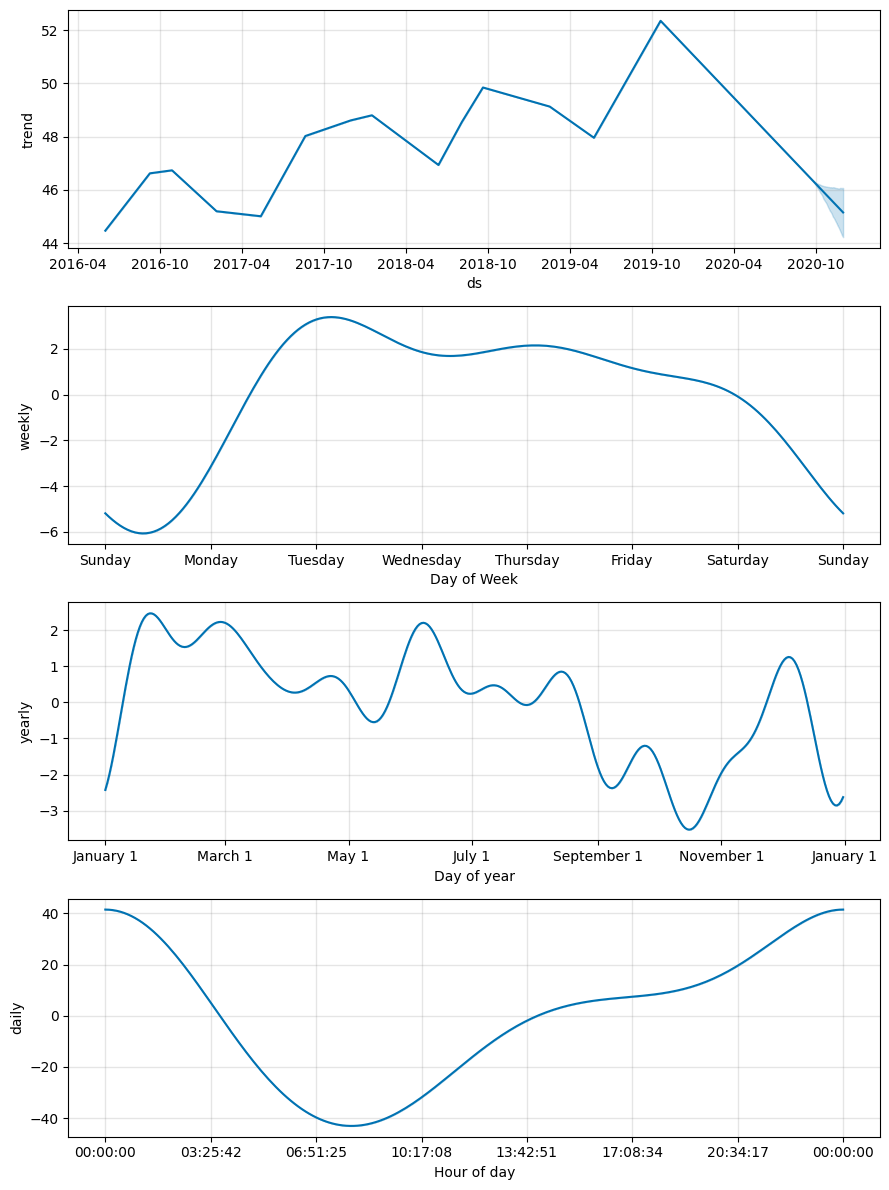

Answer the following questions based on the component plots:
1. What time of day exhibits the greatest popularity?
2. Which day of the week gets the most search traffic?
3. What's the lowest point for search traffic in the calendar year?

Time of day with highest traffic: 0 hour
Day of week with highest traffic: 1 (0=Monday, 6=Sunday)
Day of year with lowest traffic: Day 289 of the year


In [73]:
# Reset the index in the forecast_mercado_trends DataFrame


# Use the plot_components function to visualize the forecast results
# for the forecast_mercado_trends DataFrame



# Reset the index in the forecast_mercado_trends DataFrame
forecast_mercado_trends = forecast_mercado_trends.reset_index()

# Use the plot_components function to visualize the forecast results
fig = plot_components(model_mercado, forecast_mercado_trends)

# Adjust the plot layout
plt.tight_layout()

# Show the plot
plt.show()

# After viewing the plot, you can answer the following questions:
print("Answer the following questions based on the component plots:")
print("1. What time of day exhibits the greatest popularity?")
print("2. Which day of the week gets the most search traffic?")
print("3. What's the lowest point for search traffic in the calendar year?")

# You can use these lines to get the exact values if needed:
daily_seasonality = forecast_mercado_trends.groupby(forecast_mercado_trends['ds'].dt.hour)['yearly'].mean()
weekly_seasonality = forecast_mercado_trends.groupby(forecast_mercado_trends['ds'].dt.dayofweek)['weekly'].mean()
yearly_seasonality = forecast_mercado_trends.groupby(forecast_mercado_trends['ds'].dt.dayofyear)['yearly'].mean()

print(f"\nTime of day with highest traffic: {daily_seasonality.idxmax()} hour")
print(f"Day of week with highest traffic: {weekly_seasonality.idxmax()} (0=Monday, 6=Sunday)")
print(f"Day of year with lowest traffic: Day {yearly_seasonality.idxmin()} of the year")

##### Answer the following questions:

**Question:** What time of day exhibits the greatest popularity?

**Answer:** Midnight (0:00 hour or 12:00 AM) exhibits the greatest popularity for search traffic.

**Question:** Which day of week gets the most search traffic?
   
**Answer:** Tuesday gets the most search traffic. (Given that 0=Monday and 1=Tuesday in the day of week indexing)

**Question:** What's the lowest point for search traffic in the calendar year?

**Answer:** The lowest point for search traffic is on day 289 of the year, which typically falls in mid-October.
